#TASK 1: Capire il codice

##STEP 0: SETTING UP THE ENVIRONMENT

In [ ]:
import random
import numpy as np
import torch

# Impostiamo un seme per garantire la riproducibilità dei risultati
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

##STEP 1: DATA PREPARATION

### BagDataset Class
The `BagDataset` class is designed to create **bags** (representing WSIs) of  **instances** (representing patches) from the MNIST dataset.
  
Each bag:
  - Contains `bag_size × bag_size` instances (e.g., 8×8 = 64 digits per bag).
  - Is labeled as positive (`1`) if it contains at least one instance of a  specific digit (e.g., `1` for 'present'), and negative (`0`) otherwise.
  
#### Key Functions:
  - `__getitem__`: Generates a bag and assigns it a label based on the presence   of the target digit.
  - `_create_bag`: Combines individual instances into a grid-like image for   visualization.
  
#### Return:
The BagDataset Class returns a tuple with the following elements:
  - bag_image:
    - Type: `torch.Tensor`
    - Shape: `(bag_size*28, bag_size*28)`
    - Description: The tensor representing the grid-like image of the bag. Each   patch (MNIST digit image) from the bag is arranged into a larger grid with  dimensions determined by bag_size.
  - bag:
    - Type: `torch.Tensor`
    - Shape: `(patches_per_bag, 1, 28, 28)`
    - Description: The raw tensor of patches that make up the bag. Each patch   corresponds to an individual MNIST digit image, stored as a separate tensor   of shape `(1, 28, 28)` (grayscale single-channel image).
  - label:
    - Type: `int`
    - Value: either `0` or `1`
    - Description: The label of the bag. It indicates whether the bag contains a  positive patch `(label=1)` or consists entirely of negative patches `(label=0) `.
  
  This structure simplifies MIL, where the task is to classify bags instead of  individual instances.

In [ ]:
# Definizione di un dataset che crea bag numeriche da MNIST, dove le bag "negative/0" hanno tutte le patch (numeri di MNIST di shape 1,28,28) con valore 0,
# mentre le bag "positive/1" hanno almeno una patch con valore 1
# Una bag è una sorta di WSI artificiale, dove se è positiva significa che c'è il tumore in almeno una patch

class BagDataset(Dataset):
    def __init__(self, dataset, bag_size=8, positive_digit=1, negative_digit=0, seed=None):
        """
        Args:
            dataset: The MNIST dataset.
            bag_size: Number of instances along one dimension of the bag (e.g., 8 means 8x8 digit patches).
            positive_digit: The digit to include in positive bags.
            negative_digit: The digit to use for negative bags.
        """
        self.dataset = dataset #dataset MNIST
        self.bag_size = bag_size
        self.positive_digit = positive_digit #1
        self.negative_digit = negative_digit #0
        self.patches_per_bag = bag_size * bag_size #tot di patch in una bag

        self.positive_indices = [i for i, (_, label) in enumerate(dataset) if label == positive_digit] #indici delle patch/immagini MNIST che contengono 1
        self.negative_indices = [i for i, (_, label) in enumerate(dataset) if label == negative_digit] #indici delle patch/immagini MNIST che contengono 0


        self.dataset_images = torch.stack([data[0] for data in dataset], dim=0) # Contiene tutte le immagini (patch) MNIST come tensore
        self.dataset_labels = torch.tensor([data[1] for data in dataset]) # Contiene le etichette corrispondenti alle patch MNIST

        self.seed = seed

    def __len__(self):   #numero di bag
        return len(self.dataset) // self.patches_per_bag

    def __getitem__(self, idx):    #genera bag dato un indice (o tutti di 0 o un 1, randomicamente) e assegna la label

        if self.seed is not None:
            np.random.seed(self.seed + idx)
            torch.manual_seed(self.seed + idx)

        # Prepare bag
        if np.random.rand() > 0.5:
            # Positive bag
            bag_indices = np.random.choice(self.negative_indices, self.patches_per_bag - 1, replace=False).tolist()  # Seleziona come indici delle patch del bag (nr patch del bag -1) indici dagli indici delle immagini negative di MNIST
            random_pos = np.random.randint(0, self.patches_per_bag)  # Sceglie una posizione randomica nel bag per la patch positiva
            bag_indices.insert(random_pos, np.random.choice(self.positive_indices)) #inserisce nella posizione un'immagine MNIST positiva
            label = 1
        else:
            # Negative bag
            bag_indices = np.random.choice(self.negative_indices, self.patches_per_bag, replace=False).tolist() # Seleziona nr patch indici delle immagini negative
            label = 0

        # Create a bag of digit patches (usando le patch di MNIST con gli indici selezionati)
        bag = self.dataset_images[bag_indices]

        # Create a grid-like bag image for visualization
        bag_image = self._create_bag(bag)

        return bag_image, bag, label

    def _create_bag(self, patches):
        """
        Combine individual digit patches into a single bag image of shape
        (bag_size * 28, bag_size * 28), where 28x28 is the original shape of MNIST digits
        """
        bag_image = patches.view(self.bag_size, self.bag_size, 28, 28)
        bag_image = bag_image.permute(0, 2, 1, 3).contiguous()
        bag_image = bag_image.view(self.bag_size * 28, self.bag_size * 28)
        return bag_image

In [ ]:
def worker_init_fn(worker_id):
    seed = SEED + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
#Creazione del dataset di bag personalizzato usando MNIST e dei dataloader per iterare sulle Bag
# Define bag_size
bag_size = 8

# Create train and test Datasets
train_dataset = BagDataset(datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)
test_dataset = BagDataset(datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)

# Create train and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


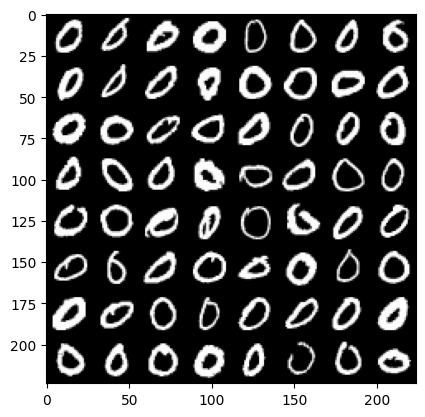

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


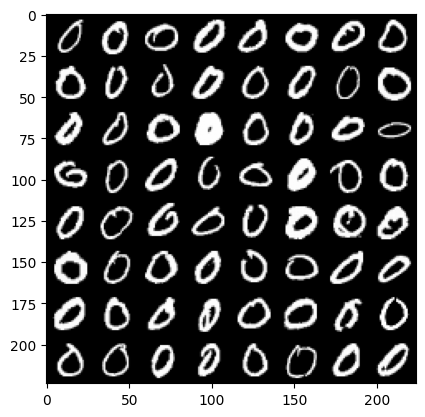

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


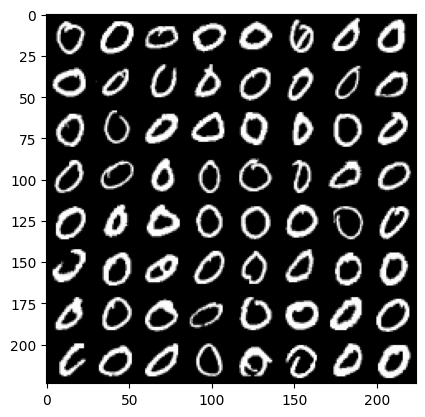

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


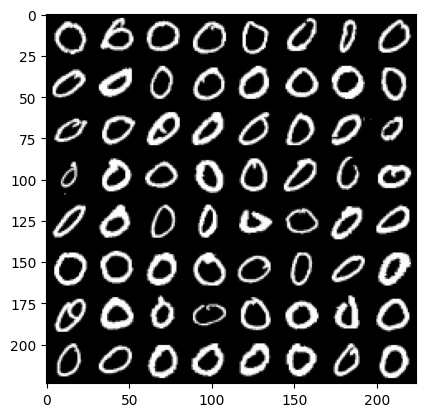

In [ ]:
# Display example bags
for i, (bag_image, bag, label) in enumerate(train_loader):
  if i == 4:
    break
  print("Bag label:", label[0].item())
  print("Bag shape:", bag[0].shape)
  plt.imshow(bag_image[0].squeeze(), cmap='gray')
  plt.show()

##STEP 2: PATCH-LEVEL FEATURE EXTRACTION AND BAG-LEVEL FEATURE POOLING

###Feature Extractor definition
The Feature Extractor is designed to convert patch-level inputs into feature vectors.
  - INPUT: patch vector with shape `input_dims` (e.g., 784 for MNIST flattened 28×28 images).
  - OUTPUT: feature vector with shape `n_hidden` (e.g., 256 for the specific pre-trained model for MNIST classification)

In [ ]:
# Definizione e inizializzazione di un Estrattore di features preallenato su MNIST (in model_urls ci sono i pesi)

from collections import OrderedDict
import torch.utils.model_zoo as model_zoo

model_urls = {
    'mnist': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth'
}

class Feature_Extractor(nn.Module):
    def __init__(self, input_dims, n_hiddens):
        super(Feature_Extractor, self).__init__()
        assert isinstance(input_dims, int), 'Please provide int for input_dims'
        self.input_dims = input_dims
        current_dims = input_dims
        layers = OrderedDict()

        if isinstance(n_hiddens, int):
            n_hiddens = [n_hiddens]
        else:
            n_hiddens = list(n_hiddens)
        for i, n_hidden in enumerate(n_hiddens):
            layers[f'fc{i+1}'] = nn.Linear(current_dims, n_hidden)
            layers[f'relu{i+1}'] = nn.ReLU()
            layers[f'drop{i+1}'] = nn.Dropout(0.2)
            current_dims = n_hidden

        self.model = nn.Sequential(layers)
        print(self.model)

    def forward(self, input):
        input = input.view(input.size(0), -1)
        assert input.size(1) == self.input_dims
        return self.model.forward(input)

### Feature Extractor initialization and pre-trained weights loading  

In [ ]:
# Initialize the Feature Extractor
feature_extractor = Feature_Extractor(input_dims=784, n_hiddens=[256, 256])  #784 perchè patch hanno dim 28*28
# Retrieve a pre-trained model for MNIST classification
state_dict = model_zoo.load_url(model_urls['mnist'])
# Load the pre-trained model weights, keeping only the feature extraction part
msg = feature_extractor.load_state_dict(state_dict, strict=False)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

###Feature Extraction and Feature Pooling
  - The function processes a bag  of MNIST patches through the Feature Extractor, computing feature vectors for each digit patch.
  - It then pools the computed patch-level features to create a single feature vector for the entire bag, using max or mean aggregation.

In [ ]:
# Il Feature extractor processa un bag e per ogni patch estrae un embedding o vettore di features
# Con Pooling aggregazione degli embedding delle patch in un unico embedding del bag

def extract_and_pool_features(bag, feature_extractor, pooling="mean"):
    bag_features = []
    # For each patch in the bag
    for i in range(bag.shape[0]):
      # Extracts patch-level features
      patch_features = feature_extractor(bag[i,:].unsqueeze(0))
      bag_features.append(patch_features.squeeze(0))
    # Stacks all patch-level features (prima in una lista) into a single tensor with shape [patches_per_bag, 256]  #256= hidden channels dim
    features = torch.stack(bag_features)
    # Pools patch-level features into a single bag-level representation with shape [256]
    if pooling == "mean":
      pooled_features = features.mean(dim=0) #media di ogni feature nella dimensione delle patches
    elif pooling == "max":
      pooled_features = features.max(dim=0)[0] #max di ogni feature tra tutte le patches
    return pooled_features

##STEP 3: MIL CLASSIFICATION

### MIL Classifier definition
The MIL Classifier is a bag-level classifier designed to take a single feature vector, representing the pooled patch-level features of the bag, and predict a binary label.
 - `nn.Linear(input_dim, 1)`: a fully connected layer maps the input feature vector (default size `256`) to a single output value.
 - `nn.Sigmoid()`: the sigmoid activation converts the output value into a probability between 0 and 1.

In [ ]:
# Definizione del modello MIL che è un classificatore binario che preso in input un embedding di bag, applica un fcl che genera un valore e sigmoide che genera probabilità tra 0 e 1
class MILClassifier(nn.Module):
    def __init__(self, input_dim=256):
        super(MILClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

### MIL Classifier initialization

In [ ]:
def initialize_weights(model):   #inizializzazione dei pesi per la riproducibilità
    for m in model.modules():
        if isinstance(m, nn.Linear):
            torch.manual_seed(SEED)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
# Initialize the MIL Classifier
classifier = MILClassifier()
# Initialize the weights for reproducibility
initialize_weights(classifier)

## STEP 4: TRAINING

In [ ]:
#Training del modello MIL

#Si scelgono una loss (binary cross entropy) e un ottimizzatore (Adam)
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01)

# Si allena il modello per n epoche sul dataset di bags di train
for epoch in range(5):
    classifier.train() #modello in modalità di training
    epoch_loss = 0

    for _, bag, label in train_loader: #valuto ogni bag del train set
        label = label.float() #label è necessaria per l'addestramento supervisionato e calcolo loss
        bag = bag.view(bag.shape[1],28*28)

        # Feature extraction and pooling
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        # Forward pass (fully connected e sigmoide)
        outputs = classifier(features)
        loss = criterion(outputs, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.6783
Epoch 2/5, Loss: 0.5790
Epoch 3/5, Loss: 0.5034
Epoch 4/5, Loss: 0.4359
Epoch 5/5, Loss: 0.4045


## STEP 5: EVALUATION

In [ ]:
classifier.eval() #modello in modalità di inferenza
correct = 0
total = 0

with torch.no_grad():
    for _, bag, label in test_loader: #valuto ogni bag del test set
        label = label.float()
        bag = bag.view(bag.shape[1],28*28)

        # Feature extraction and pooling
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        # Predictions
        outputs = classifier(features)   #predizione del modello dato l'embedding del bag
        predicted = (outputs > 0.5).float()
        correct += (predicted == label).sum().item()
        total += label.size(0)

print(f"Test Accuracy: {correct / total:.2f}")


Test Accuracy: 0.92


#TASK 2: Aumentare istanze positive e analizzare su mean e max pooling

In [ ]:
class BagDataset_more_positives(Dataset):
    def __init__(self, dataset, bag_size=8, positive_digit=1, negative_digit=0, seed=None):
        """
        Args:
            dataset: The MNIST dataset.
            bag_size: Number of instances along one dimension of the bag (e.g., 8 means 8x8 digit patches).
            positive_digit: The digit to include in positive bags.
            negative_digit: The digit to use for negative bags.
        """
        self.dataset = dataset
        self.bag_size = bag_size
        self.positive_digit = positive_digit
        self.negative_digit = negative_digit
        self.patches_per_bag = bag_size * bag_size

        self.positive_indices = [i for i, (_, label) in enumerate(dataset) if label == positive_digit]
        self.negative_indices = [i for i, (_, label) in enumerate(dataset) if label == negative_digit]

        self.dataset_images = torch.stack([data[0] for data in dataset], dim=0)
        self.dataset_labels = torch.tensor([data[1] for data in dataset])

        self.seed = seed

    def __len__(self):
        return len(self.dataset) // self.patches_per_bag

    def __getitem__(self, idx):

        if self.seed is not None:
            np.random.seed(self.seed + idx)
            torch.manual_seed(self.seed + idx)

        ''' Incremento il numero di istanze positive in un bag a 7'''
        # Prepare bag
        if np.random.rand() > 0.5:
            # Positive bag
            bag_indices = np.random.choice(self.negative_indices, self.patches_per_bag - 7, replace=False).tolist()
            random_positions = np.random.choice(self.patches_per_bag, 7, replace=False)  # 7 posizioni casuali tra gli indici delle patch
            for pos in sorted(random_positions, reverse=True):  # Inserisce le cifre positive (prima quelle con indice più alto)
                bag_indices.insert(pos, np.random.choice(self.positive_indices))
            label = 1
        else:
            # Negative bag
            bag_indices = np.random.choice(self.negative_indices, self.patches_per_bag, replace=False).tolist()
            label = 0

        # Create a bag of digit patches
        bag = self.dataset_images[bag_indices]

        # Create a grid-like bag image for visualization
        bag_image = self._create_bag(bag)

        return bag_image, bag, label

    def _create_bag(self, patches):
        """
        Combine individual digit patches into a single bag image of shape
        (bag_size * 28, bag_size * 28), where 28x28 is the original shape of MNIST digits
        """
        bag_image = patches.view(self.bag_size, self.bag_size, 28, 28)
        bag_image = bag_image.permute(0, 2, 1, 3).contiguous()
        bag_image = bag_image.view(self.bag_size * 28, self.bag_size * 28)
        return bag_image

In [ ]:
# Define bag_size
bag_size = 8

# Create train and test Datasets
train_dataset_more_positives = BagDataset_more_positives(datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)
test_dataset_more_positives = BagDataset_more_positives(datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)

# Create train and test DataLoaders
train_loader_more_positives = DataLoader(train_dataset_more_positives, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)
test_loader_more_positives = DataLoader(test_dataset_more_positives, batch_size=1, shuffle=False, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


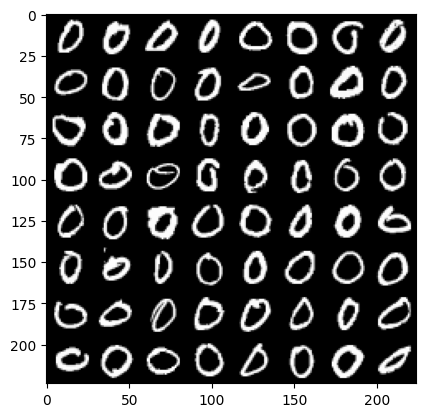

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


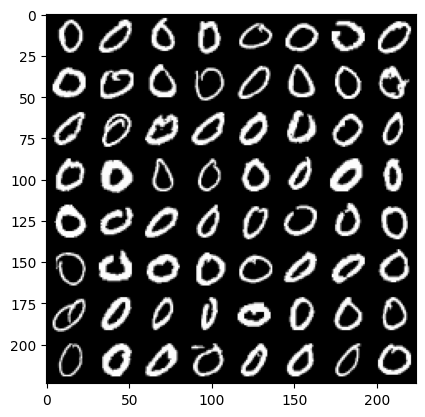

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


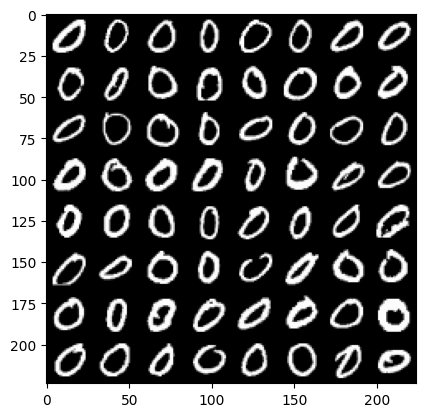

Bag label: 1
Bag shape: torch.Size([64, 1, 28, 28])


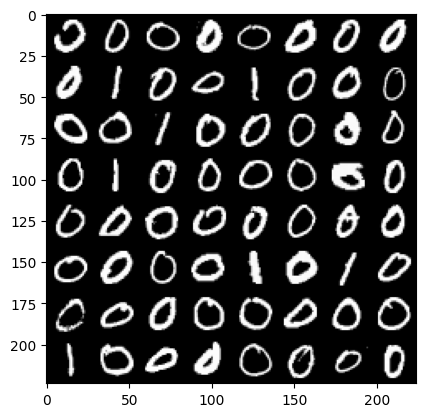

In [ ]:
# Display example bags
for i, (bag_image, bag, label) in enumerate(train_loader_more_positives):
  if i == 4:
    break
  print("Bag label:", label[0].item())
  print("Bag shape:", bag[0].shape)
  plt.imshow(bag_image[0].squeeze(), cmap='gray')
  plt.show()

In [ ]:
# Nel task precedente ho trainato il modello sul dataset Bagdataset e con il meanpooling.
# Ora devo riaddestrare e testare il modello con meanpooling sul nuovo dataset e con maxpooling su entrambi i dataset

classifier_mean_old = classifier   #già addestrato con vecchio dataset e meanpooling

classifier_mean_new = MILClassifier()  #da addestrare con nuovo dataset e meanpooling
initialize_weights(classifier_mean_new)

classifier_max_old = MILClassifier()   #da addestrare con vecchio dataset e maxpooling
initialize_weights(classifier_max_old)

classifier_max_new = MILClassifier()   #da addestrare con nuovo dataset e maxpooling
initialize_weights(classifier_max_new)

In [ ]:
#Training dei tre classificatori

criterion = nn.BCELoss()
# Ottimizzatori separati per ciascun modello
optimizer_mean_new = optim.Adam(classifier_mean_new.parameters(), lr=0.01)
optimizer_max_old = optim.Adam(classifier_max_old.parameters(), lr=0.01)
optimizer_max_new = optim.Adam(classifier_max_new.parameters(), lr=0.01)

# Addestramento per ogni modello
for epoch in range(5):  # numero di epoche
    # Addestramento per classifier_mean_new (mean pooling con nuovo dataset)
    classifier_mean_new.train()
    epoch_loss = 0
    for _, bag, label in train_loader_more_positives:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)

        # Estrazione e pooling delle features
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        outputs = classifier_mean_new(features)
        loss = criterion(outputs, label)

        optimizer_mean_new.zero_grad()
        loss.backward()
        optimizer_mean_new.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5} - Mean New, Loss: {epoch_loss/len(train_loader_more_positives):.4f}")

    # Addestramento per classifier_max_old (max pooling con vecchio dataset)
    classifier_max_old.train()
    epoch_loss = 0
    for _, bag, label in train_loader:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)

        # Estrazione e pooling delle features
        features = extract_and_pool_features(bag, feature_extractor, pooling="max")

        outputs = classifier_max_old(features)
        loss = criterion(outputs, label)

        optimizer_max_old.zero_grad()
        loss.backward()
        optimizer_max_old.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5} - Max Old, Loss: {epoch_loss/len(train_loader):.4f}")

    # Addestramento per classifier_max_new (max pooling con nuovo dataset)
    classifier_max_new.train()
    epoch_loss = 0
    for _, bag, label in train_loader_more_positives:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)

        # Estrazione e pooling delle features
        features = extract_and_pool_features(bag, feature_extractor, pooling="max")

        outputs = classifier_max_new(features)
        loss = criterion(outputs, label)

        optimizer_max_new.zero_grad()
        loss.backward()
        optimizer_max_new.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5} - Max New, Loss: {epoch_loss/len(train_loader_more_positives):.4f}")

Epoch 1/5 - Mean New, Loss: 0.2204
Epoch 1/5 - Max Old, Loss: 0.2559
Epoch 1/5 - Max New, Loss: 0.0721
Epoch 2/5 - Mean New, Loss: 0.0355
Epoch 2/5 - Max Old, Loss: 0.1127
Epoch 2/5 - Max New, Loss: 0.0038
Epoch 3/5 - Mean New, Loss: 0.0146
Epoch 3/5 - Max Old, Loss: 0.0802
Epoch 3/5 - Max New, Loss: 0.0017
Epoch 4/5 - Mean New, Loss: 0.0076
Epoch 4/5 - Max Old, Loss: 0.0636
Epoch 4/5 - Max New, Loss: 0.0008
Epoch 5/5 - Mean New, Loss: 0.0043
Epoch 5/5 - Max Old, Loss: 0.0790
Epoch 5/5 - Max New, Loss: 0.0005


In [ ]:
#Testing dei quattro modelli:

from sklearn.metrics import precision_score, recall_score, accuracy_score

'''Vecchio dataset e Meanpooling'''
classifier_mean_old.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for _, bag, label in test_loader:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")
        outputs = classifier_mean_old(features)
        predicted = (outputs > 0.5).float()
        all_labels.extend(label.cpu().numpy())  # Usa .cpu().numpy() per spostare i tensori su CPU
        all_predictions.extend(predicted.cpu().numpy())

# Calcola le metriche
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

# Stampa le metriche
print(f"Test Accuracy on OLD dataset, MEANPOOLING: {accuracy:.2f}")
print(f"Test Precision on OLD dataset, MEANPOOLING: {precision:.2f}")
print(f"Test Recall on OLD dataset, MEANPOOLING: {recall:.2f}")
print("\n")


'''Vecchio dataset e Maxpooling'''
classifier_max_old.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for _, bag, label in test_loader:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)
        features = extract_and_pool_features(bag, feature_extractor, pooling="max")
        outputs = classifier_max_old(features)
        predicted = (outputs > 0.5).float()
        all_labels.extend(label.cpu().numpy())  # Usa .cpu().numpy() per spostare i tensori su CPU
        all_predictions.extend(predicted.cpu().numpy())

# Calcola le metriche
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

# Stampa le metriche
print(f"Test Accuracy on OLD dataset, MAXPOOLING: {accuracy:.2f}")
print(f"Test Precision on OLD dataset, MAXPOOLING: {precision:.2f}")
print(f"Test Recall on OLD dataset, MAXPOOLING: {recall:.2f}")
print("\n")


'''Nuovo dataset e Meanpooling'''
classifier_mean_new.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for _, bag, label in test_loader_more_positives:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")
        outputs = classifier_mean_new(features)
        predicted = (outputs > 0.5).float()
        all_labels.extend(label.cpu().numpy())  # Usa .cpu().numpy() per spostare i tensori su CPU
        all_predictions.extend(predicted.cpu().numpy())

# Calcola le metriche
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

# Stampa le metriche
print(f"Test Accuracy on NEW dataset, MEANPOOLING: {accuracy:.2f}")
print(f"Test Precision on NEW dataset, MEANPOOLING: {precision:.2f}")
print(f"Test Recall on NEW dataset, MEANPOOLING: {recall:.2f}")
print("\n")


'''Nuovo dataset e Maxpooling'''
classifier_max_new.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for _, bag, label in test_loader_more_positives:
        label = label.float()
        bag = bag.view(bag.shape[1], 28*28)
        features = extract_and_pool_features(bag, feature_extractor, pooling="max")
        outputs = classifier_max_new(features)
        predicted = (outputs > 0.5).float()
        all_labels.extend(label.cpu().numpy())  # Usa .cpu().numpy() per spostare i tensori su CPU
        all_predictions.extend(predicted.cpu().numpy())

# Calcola le metriche
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

# Stampa le metriche
print(f"Test Accuracy on NEW dataset, MAXPOOLING: {accuracy:.2f}")
print(f"Test Precision on NEW dataset, MAXPOOLING: {precision:.2f}")
print(f"Test Recall on NEW dataset, MAXPOOLING: {recall:.2f}")
print("\n")

Test Accuracy on OLD dataset, MEANPOOLING: 0.92
Test Precision on OLD dataset, MEANPOOLING: 0.97
Test Recall on OLD dataset, MEANPOOLING: 0.88


Test Accuracy on OLD dataset, MAXPOOLING: 0.97
Test Precision on OLD dataset, MAXPOOLING: 1.00
Test Recall on OLD dataset, MAXPOOLING: 0.94


Test Accuracy on NEW dataset, MEANPOOLING: 1.00
Test Precision on NEW dataset, MEANPOOLING: 1.00
Test Recall on NEW dataset, MEANPOOLING: 1.00


Test Accuracy on NEW dataset, MAXPOOLING: 1.00
Test Precision on NEW dataset, MAXPOOLING: 1.00
Test Recall on NEW dataset, MAXPOOLING: 1.00




#TASK 3: MULTI-CLASS CLASSIFICATION

In [ ]:
# Per questo task di MIL multi-class classification scelgo la regola di Majority-Rule:
# Un bag è di classe i, se la prevalenza delle sue patch sono di classe i

class MultiClassBagDataset(Dataset):
    def __init__(self, dataset, bag_size=8, seed=None):
        """
        Args:
            dataset: The MNIST dataset.
            bag_size: Number of instances along one dimension of the bag (e.g., 8 means 8x8 digit patches).
            seed: Optional seed for reproducibility.
        """
        self.dataset = dataset
        self.bag_size = bag_size
        self.patches_per_bag = bag_size * bag_size

        # Raggruppo gli indici delle immagini del dataset per la loro label (0-9) in un dizionario
        self.label_indices = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(dataset):
            self.label_indices[label].append(idx)   #label_indices (chiave=label, val=indice immagine)

        self.dataset_images = torch.stack([data[0] for data in dataset], dim=0)
        self.dataset_labels = torch.tensor([data[1] for data in dataset])

        self.seed = seed

    def __len__(self):
        # Number of bags is the total number of images divided by the patches per bag
        return len(self.dataset) // self.patches_per_bag

    def __getitem__(self, idx):
        if self.seed is not None:
            np.random.seed(self.seed + idx)
            torch.manual_seed(self.seed + idx)

        # Scelgo una label di bag tra (0-9)
        bag_class = np.random.randint(0, 10)

        # Creo bag dove più della metà delle patch sono della label scelta, cosi sono sicura che sia la classe prevalente
        num_instances_from_bag_class = np.random.randint(self.patches_per_bag // 2 + 1, self.patches_per_bag + 1) #nr di patch della label scelta è tra metà e tutto il bag
        bag_indices=np.random.choice(self.label_indices[bag_class], num_instances_from_bag_class, replace=False).tolist()#scelgo gli indici delle patch della classe scelta

        # Riempio il bag con patch casuali dal dataset (senza preoccuparti della classe)
        remaining_instances = self.patches_per_bag - len(bag_indices)
        all_indices = np.random.choice(len(self.dataset), remaining_instances, replace=False).tolist()  # Selezione casuale tra tutte le immagini

        # Inserisco le patch casuali nelle posizioni casuali nel bag_indices
        random_positions = np.random.choice(len(bag_indices) + remaining_instances, remaining_instances, replace=False)
        random_positions = sorted(random_positions, reverse=True)
        for pos in random_positions:
            # Selezioniamo una patch casuale e la inseriamo nella posizione casuale
            patch = all_indices.pop()  # Prendi l'ultimo elemento di all_indices
            bag_indices.insert(pos, patch)

        label = bag_class

        # Create a bag of digit patches
        bag = self.dataset_images[bag_indices]

        # Create a grid-like bag image for visualization
        bag_image = self._create_bag(bag)

        return bag_image, bag, label

    def _create_bag(self, patches):
        """
        Combine individual digit patches into a single bag image of shape
        (bag_size * 28, bag_size * 28), where 28x28 is the original shape of MNIST digits
        """
        bag_image = patches.view(self.bag_size, self.bag_size, 28, 28)
        bag_image = bag_image.permute(0, 2, 1, 3).contiguous()
        bag_image = bag_image.view(self.bag_size * 28, self.bag_size * 28)
        return bag_image


In [ ]:
def worker_init_fn(worker_id):
    seed = SEED + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
# Define bag_size
bag_size = 8

# Create train and test Datasets
train_dataset_multiclass = MultiClassBagDataset(datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)
test_dataset_multiclass = MultiClassBagDataset(datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)

# Create train and test DataLoaders
train_loader_multiclass = DataLoader(train_dataset_multiclass, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)
test_loader_multiclass = DataLoader(test_dataset_multiclass, batch_size=1, shuffle=False, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.22MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.37MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Bag label: 6
Bag shape: torch.Size([64, 1, 28, 28])


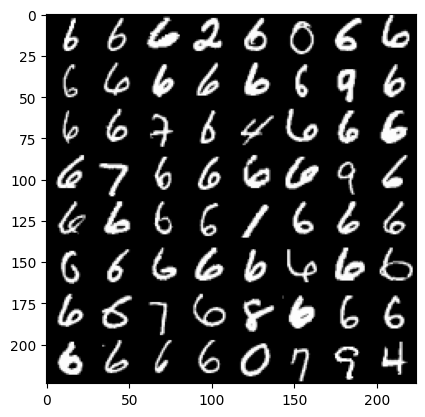

Bag label: 4
Bag shape: torch.Size([64, 1, 28, 28])


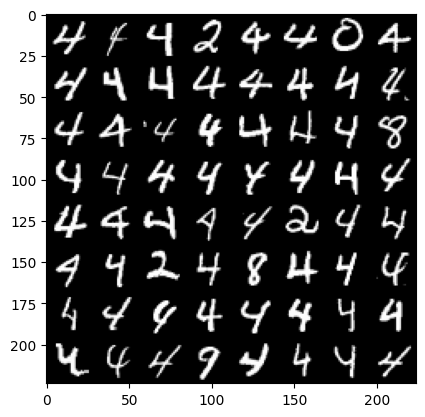

Bag label: 3
Bag shape: torch.Size([64, 1, 28, 28])


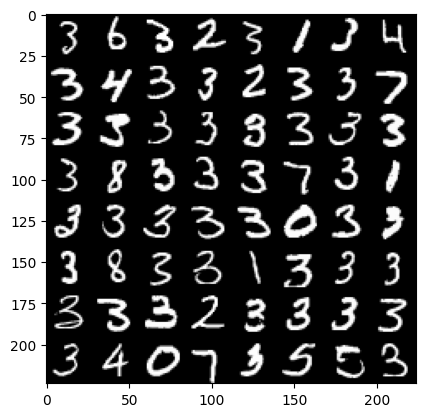

Bag label: 6
Bag shape: torch.Size([64, 1, 28, 28])


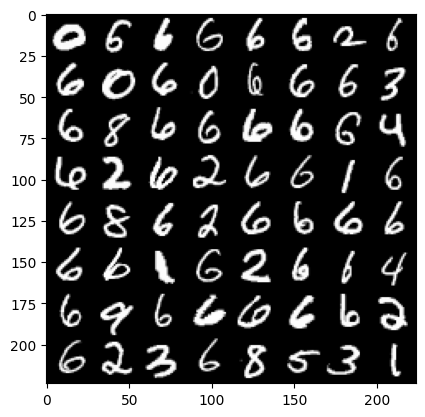

In [ ]:
# Display example bags
for i, (bag_image, bag, label) in enumerate(train_loader_multiclass):
  if i == 4:
    break
  print("Bag label:", label[0].item())
  print("Bag shape:", bag[0].shape)
  plt.imshow(bag_image[0].squeeze(), cmap='gray')
  plt.show()

In [ ]:
#il Feature extractor e pooling rimangono gli stessi, cambia il classificatore
#il MIL classifier dato l'embedding della bag deve prevedere una classe da 0 a 9

class MultiClassMILClassifier(nn.Module):
    def __init__(self, input_dim=256, num_classes=10):
        super(MultiClassMILClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),  # Layer di feature embedding
            nn.ReLU(),
            nn.Linear(128, num_classes)  # L'output sarà un vettore di dimensione num_classes (10 nel nostro caso)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
def initialize_weights(model):  #resta uguale
    for m in model.modules():
        if isinstance(m, nn.Linear):
            torch.manual_seed(SEED)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
# Inizializzo i classificatori multiclasse, uno sarà allenato con Meanpooling, l'altro con Maxpooling
classifier_multiclass_mean = MultiClassMILClassifier()
initialize_weights(classifier_multiclass_mean)


classifier_multiclass_max = MultiClassMILClassifier()
initialize_weights(classifier_multiclass_max)


In [ ]:
# Alleno i due classificatori sul dataset multiclasse
# Uso la CrossEntropyLoss che contiene la Softmax per la classificazione multiclasse
criterion = nn.CrossEntropyLoss()
optimizer_mean = optim.Adam(classifier_multiclass_mean.parameters(), lr=0.01)
optimizer_max = optim.Adam(classifier_multiclass_mean.parameters(), lr=0.01)

for epoch in range(5):

    # Con Meanpooling
    classifier_multiclass_mean.train()
    epoch_loss = 0

    for _, bag, label in train_loader_multiclass:
        # In un problema multiclass, il label deve essere un intero che rappresenta la classe
        label = label.squeeze().long()  # Converte la label in tensore di tipo long (necessario per CrossEntropyLoss)
        bag = bag.view(bag.shape[1],28*28)

        # Estrazione e pooling delle caratteristiche
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        # Forward pass
        outputs = classifier_multiclass_mean(features)  # Calcola le probabilità per ciascuna classe
        loss = criterion(outputs, label)  # La loss accetta label come indici di classe

        # Backward pass
        optimizer_mean.zero_grad()
        loss.backward()
        optimizer_mean.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5}, Mean Multiclass, Loss: {epoch_loss/len(train_loader):.4f}")


    # Con Maxpooling
    classifier_multiclass_max.train()
    epoch_loss = 0

    for _, bag, label in train_loader_multiclass:
        # In un problema multiclass, il label deve essere un intero che rappresenta la classe
        label = label.squeeze().long()  # Converte la label in tensore di tipo long (necessario per CrossEntropyLoss)
        bag = bag.view(bag.shape[1],28*28)

        # Estrazione e pooling delle caratteristiche
        features = extract_and_pool_features(bag, feature_extractor, pooling="max")

        # Forward pass
        outputs = classifier_multiclass_max(features)  # Calcola le probabilità per ciascuna classe
        loss = criterion(outputs, label)  # La loss accetta label come indici di classe

        # Backward pass
        optimizer_max.zero_grad()
        loss.backward()
        optimizer_max.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5}, Max Multiclass, Loss: {epoch_loss/len(train_loader):.4f}")


NameError: name 'nn' is not defined

In [ ]:
#Testing con Meanpooling
classifier_multiclass_mean.eval()  # Impostiamo il modello in modalità evaluation
correct = 0
total = 0

with torch.no_grad():
    for _, bag, label in test_loader_multiclass:
        label = label.long()  # Cambia il tipo di label per compatibilità con CrossEntropyLoss
        bag = bag.view(bag.shape[1],28*28)

        # Estrazione delle features e pooling
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        # Predizione delle classi
        outputs = classifier_multiclass_mean(features)
        _, predicted = torch.max(outputs, 1)  # Argmax per ottenere la classe con la probabilità più alta
        correct += (predicted == label).sum().item()  # Confronta la predizione con la label vera
        total += label.size(0)  # Conta il numero di esempi nel batch

# Calcola l'accuratezza
print(f"Test Accuracy del modello MultiClass con Meanpooling: {correct / total:.2f}")


#Testing con Maxpooling
classifier_multiclass_max.eval()  # Impostiamo il modello in modalità evaluation
correct = 0
total = 0

with torch.no_grad():
    for _, bag, label in test_loader_multiclass:
        label = label.long()  # Cambia il tipo di label per compatibilità con CrossEntropyLoss
        bag = bag.view(bag.shape[1],28*28)

        # Estrazione delle features e pooling
        features = extract_and_pool_features(bag, feature_extractor, pooling="max")

        # Predizione delle classi
        outputs = classifier_multiclass_max(features)
        _, predicted = torch.max(outputs, 1)  # Argmax per ottenere la classe con la probabilità più alta
        correct += (predicted == label).sum().item()  # Confronta la predizione con la label vera
        total += label.size(0)  # Conta il numero di esempi nel batch

# Calcola l'accuratezza
print(f"Test Accuracy del modello MultiClass con Maxpooling: {correct / total:.2f}")